In [2]:
import json
import new_env
import copy
import numpy as np

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
with open("dataset.json") as fp:
    dataset = json.load(fp)


env = new_env.HolEnv("T")
paper_goals = []
for goal in dataset:
    try:
        p_goal = env.get_polish(goal)
        paper_goals.append((p_goal[0]["polished"]['goal'], goal))
    except:
        print (goal)

Importing theories...
Loading modules...
Configuration done.
DATATYPE ((sum :(α -> α + β) -> (β -> α + β) -> γ) (INL :α -> α + β) (INR :β -> α + β))
∀(A :α -> bool) (B :β -> bool) (C :α -> bool) (D :β -> bool). A × B ∩ (C × D) = A ∩ C × (B ∩ D)
DATATYPE ((list :α list -> (α -> α list -> α list) -> bool) ([] :α list) (CONS :α -> α list -> α list))


In [5]:
polished = [i for i in map(lambda x: x[0], paper_goals)]

In [6]:
print (polished[0])

@ C$bool$ ! | Vs1 @ C$bool$ ! | Vs2 @ @ C$min$ = @ @ C$pred_set$ PSUBSET Vs1 Vs2 @ @ C$bool$ /\ @ @ C$pred_set$ SUBSET Vs1 Vs2 @ C$bool$ ~ @ @ C$pred_set$ SUBSET Vs2 Vs1


In [7]:
class AST:
    def __init__(self, node, children=[], parent=None):
        self.node = node
        self.children = children
        self.parent = [parent]
    def _print(self, depth=1):
        print (depth * "--- " + self.node.value)
        if len(self.children) > 0:
            for child in self.children:
                child._print(depth+1)
        
class Token:
    def __init__(self, value, _type, arity=None):
        self.value = value
        self._type = _type
        self.arity = arity
    
#assume ast has been passed with ast.node as function 
def func_to_ast(ast, tokens, arity):
    if len(tokens) == 0:
        return ast

    node = tokens[0]
    tokens.pop(0)

    new_node = AST(node, children = [], parent=ast)
    
    if node._type == "variable":

        ast.children.append(new_node)

    elif node._type == "func" or node._type == "lambda":

        new_ast = func_to_ast(new_node, tokens, node.arity)
        ast.children.append(new_ast)
      
        
    if arity == 1:
        return ast
    else:
        return func_to_ast(ast, tokens, arity-1)
    
def tokens_to_ast(tokens):
    ast = AST(tokens[0], children=[])
    tokens.pop(0)
    return func_to_ast(ast, tokens, ast.node.arity)


In [8]:
def polished_to_tokens_2(goal):
    polished_goal = goal.split(" ")
    tokens = []
    
    while len(polished_goal) > 0:
        if polished_goal[0] == '@':
            polished_goal.pop(0)
            arity = 1
            
            while polished_goal[0] == '@':
                arity += 1
                polished_goal.pop(0)
                
            func = polished_goal[0]
            polished_goal.pop(0)
            
#             #quantifiers should be considered with arity 2 for constructing the tree (for now?)?
#             if func == 'C$bool$' and (polished_goal[0] == '!' or polished_goal[0] == '?') and polished_goal[1] == "|":
#                     #arity = 2
#                     #as there's 2 space separated characters for quantifiers
#                     func = func + "|" + polished_goal[0] #+ polished_goal[1]
#                     polished_goal.pop(0)
#                     tokens.append(Token(func, "quantifier", arity))

                    
#           else:
            if func[0] == 'C':
                #should only be one string after the library 
                func = func + "|" + polished_goal[0]
                polished_goal.pop(0)
        #otherwise variable func, and nothing following it

            tokens.append(Token(func, "func", arity))
        
        #variable or constant case
        else:
            var = polished_goal[0]
            polished_goal.pop(0)
            #lambda case
            if var[0] == "|":
                tokens.append(Token("".join(var), "lambda", 2))
            else:
            
                if var[0] == "C":
                    #need to append this and the next as constants are space separated
                    var = var + polished_goal[0]
                    polished_goal.pop(0)

                tokens.append(Token("".join(var), "variable"))

    return tokens
            

In [9]:
def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

In [10]:
def print_graph(ast):
    G = nx.DiGraph()
    add_node(ast, G)
    
    labels = nx.get_node_attributes(G, 'value')
    pos = hierarchy_pos(G,ast.node)    
    plt.figure(1,figsize=(15,30)) 
    nx.draw(G, pos=pos, labels=labels, with_labels=True,
            arrowsize=20,
            node_color='none',
            node_size=6000)#, font_weight='bold')
    
    
    labels = {e: G.get_edge_data(e[0], e[1])["child"] for e in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    ax = plt.gca() # to get the current axis
    ax.collections[0].set_edgecolor("#FF0000") 
    plt.savefig("Graph.png", format="PNG")
    #plt.show()
# 0

def add_node(ast, graph):
    graph.add_node(ast.node, value = str(ast.node.value))
    for i, child in enumerate(ast.children):
        graph.add_edge(ast.node, child.node, child=i)
        add_node(child, graph)
    
#verticalalignment='bottom'

In [26]:
def add_lambda_children(lambda_ast):
    #child should be '|' with first child of that as variable, and rest as quantified scope
    var = lambda_ast.children[0].node.value
    sub_tree = lambda_ast.children[1]
    print ("outer")
    print (lambda_ast.node, [x.node.value for x in lambda_ast.children])
    #edge case
    if sub_tree.node.value == var:
        return lambda_ast
    
    def apply_lambda(ast, var):
        print ("inner")
        print (ast.node.value, [x.node.value for x in ast.children])

        if ast.node.value == var:
            lambda_ast.children.append(ast)
            ast.parent.append(lambda_ast)
            for child in ast.children:
                apply_lambda(child,var) 
        else:
            for child in ast.children:
                apply_lambda(child,var)
        return
    
    apply_lambda(sub_tree, var)
    return lambda_ast
    
#TODO Needs to be changed to lambda values. lambdas should have first child as variable, then subsequent child as scope 
#where it is defined. Generalises quantifiers here 
def process_lambdas(ast):
    if ast.node._type == 'lambda':
        add_lambda_children(ast)
        for child in ast.children:
            process_lambdas(child)
    else:
        for child in ast.children:
            process_lambdas(child)
    return ast


In [21]:
def merge_leaves(ast):
    leaves = []

    def get_leaves(ast):
        if ast.children == []:
            leaves.append(ast)
        else:
            for child in ast.children:
                get_leaves(child)
        return
    
    get_leaves(ast)
    
    leaf_tokens = set(leaves)
    leaf_values = set([x.node.value for x in leaves])
    
    lambda_tokens = []
    #only merge leaf nodes if they're within the same quantified scope
    
    #run for all quantifiers (process_quantifiers but with get leaves as inner function)
    def run_lambdas(lambda_ast):
        var = lambda_ast.children[0].node.value
        print (var)
        print ([c.node.value for c in lambda_ast.children])

        sub_tree = lambda_ast.children[1]
        lambda_token = lambda_ast.children[0]
        lambda_tokens.append(lambda_token)
        
        
        def merge_lambda(ast, var):
            #if quantified variable, and leaf node, point parents to original node
            if ast.node.value == var and ast.children == []:
                #this way ensures no duplicates 
                for parent in ast.parent:
                    new_children = []
                    flag = False
                    for c in parent.children:
                        if c.node.value != var or c.children != []:
                            new_children.append(c)
                        elif flag == False:
                            new_children.append(lambda_token)
                            flag = True
                    parent.children = new_children
                
            for child in ast.children:
                merge_lambda(child,var) 

            return ast 

        merge_lambda(sub_tree, var)
        return lambda_ast
    
    def merge_all_lambdas(ast):
        if ast.node._type == 'lambda':
            run_lambdas(ast)
            for child in ast.children:
                merge_all_lambdas(child)
        else:
            for child in ast.children:
                merge_all_lambdas(child)
        return ast    
    
    merge_all_lambdas(ast)
    
    #TODO no quantifier case
    print (set(lambda_tokens) - leaf_tokens)

                
    return ast
        
    

In [13]:
def rename(ast):
    if ast.node.value[0] == 'V':
        if ast.children != []:
            ast.node.value = "VARFUNC"
        else:
            ast.node.value = "VAR"

    for child in ast.children:
        rename(child)
    
    return ast


In [151]:
def goal_to_graph(polished_goal):
    return rename(merge_leaves(process_lambdas(tokens_to_ast(polished_to_tokens_2(polished_goal)))))

In [16]:
#get all unique tokens from database 

with open("new_db.json") as fp:
    db = json.load(fp)
    

polished_goals = []
for val in db.values():
    polished_goals.append(val[2])

tokens = list(set([token.value for polished_goal in polished_goals for token in polished_to_tokens_2(polished_goal)  if token.value[0] != 'V']))

tokens.append("VAR")
tokens.append("VARFUNC")
tokens.append("UNKNOWN")

#print (len(tokens))

In [29]:
# for i,g in enumerate(polished_goals):
#     print (g)
#     print (i)
#     goal_to_graph(g)

In [56]:
[i for i in db.values() if i[2] == polished_goals[2081]]

[['bool',
  'BOOL_FUN_INDUCT',
  '@ C$bool$ ! | VP @ @ C$min$ ==> @ @ C$bool$ /\\ @ VP | Vb C$bool$ T @ @ C$bool$ /\\ @ VP | Vb C$bool$ F @ @ C$bool$ /\\ @ VP | Vb Vb @ VP | Vb @ C$bool$ ~ Vb @ C$bool$ ! | Vf @ VP Vf',
  '165',
  'thm',
  '∀(P :(bool -> bool) -> bool). P (λ(b :bool). T) ∧ P (λ(b :bool). F) ∧ P (λ(b :bool). b) ∧ P (λ(b :bool). ¬b) ⇒ ∀(f :bool -> bool). P f']]

In [14]:
print_graph(goal_to_graph(polished_goals[2081]))

NameError: name 'goal_to_graph' is not defined

In [41]:
ret = []
def get_lambdas(ast):
    if ast.node._type == "lambda":
        print ("asdf")
        ret.append(ast.node)
    for child in ast.children:
        get_lambdas(child)
    return

In [42]:
get_lambdas(tokens_to_ast(polished_to_tokens_2(polished_goals[2081])))

asdf
asdf
asdf
asdf
asdf
asdf


In [43]:
ret

outer
<__main__.Token object at 0x7f18b5fe7a90> ['VP', 'C$min$|==>']
inner
C$min$|==> ['C$bool$|/\\', 'C$bool$|!']
inner
C$bool$|/\ ['VP', 'C$bool$|/\\']
inner
VP ['|']
inner
| ['Vb', 'C$bool$T']
inner
Vb []
inner
C$bool$T []
inner
C$bool$|/\ ['VP', 'C$bool$|/\\']
inner
VP ['|']
inner
| ['Vb', 'C$bool$F']
inner
Vb []
inner
C$bool$F []
inner
C$bool$|/\ ['VP', 'VP']
inner
VP ['|']
inner
| ['Vb', 'Vb']
inner
Vb []
inner
Vb []
inner
VP ['|']
inner
| ['Vb', 'C$bool$|~']
inner
Vb []
inner
C$bool$|~ ['Vb']
inner
Vb []
inner
C$bool$|! ['|']
inner
| ['Vf', 'VP']
inner
Vf []
inner
VP ['Vf']
inner
Vf []
outer
<__main__.Token object at 0x7f18b5ffbd00> ['Vb', 'C$bool$T']
inner
C$bool$T []
outer
<__main__.Token object at 0x7f18b625f1c0> ['Vb', 'C$bool$F']
inner
C$bool$F []
outer
<__main__.Token object at 0x7f18b6844a00> ['Vb', 'Vb']
outer
<__main__.Token object at 0x7f18b627feb0> ['Vb', 'C$bool$|~']
inner
C$bool$|~ ['Vb']
inner
Vb []
outer
<__main__.Token object at 0x7f18b628b670> ['Vf', 'VP']
inner

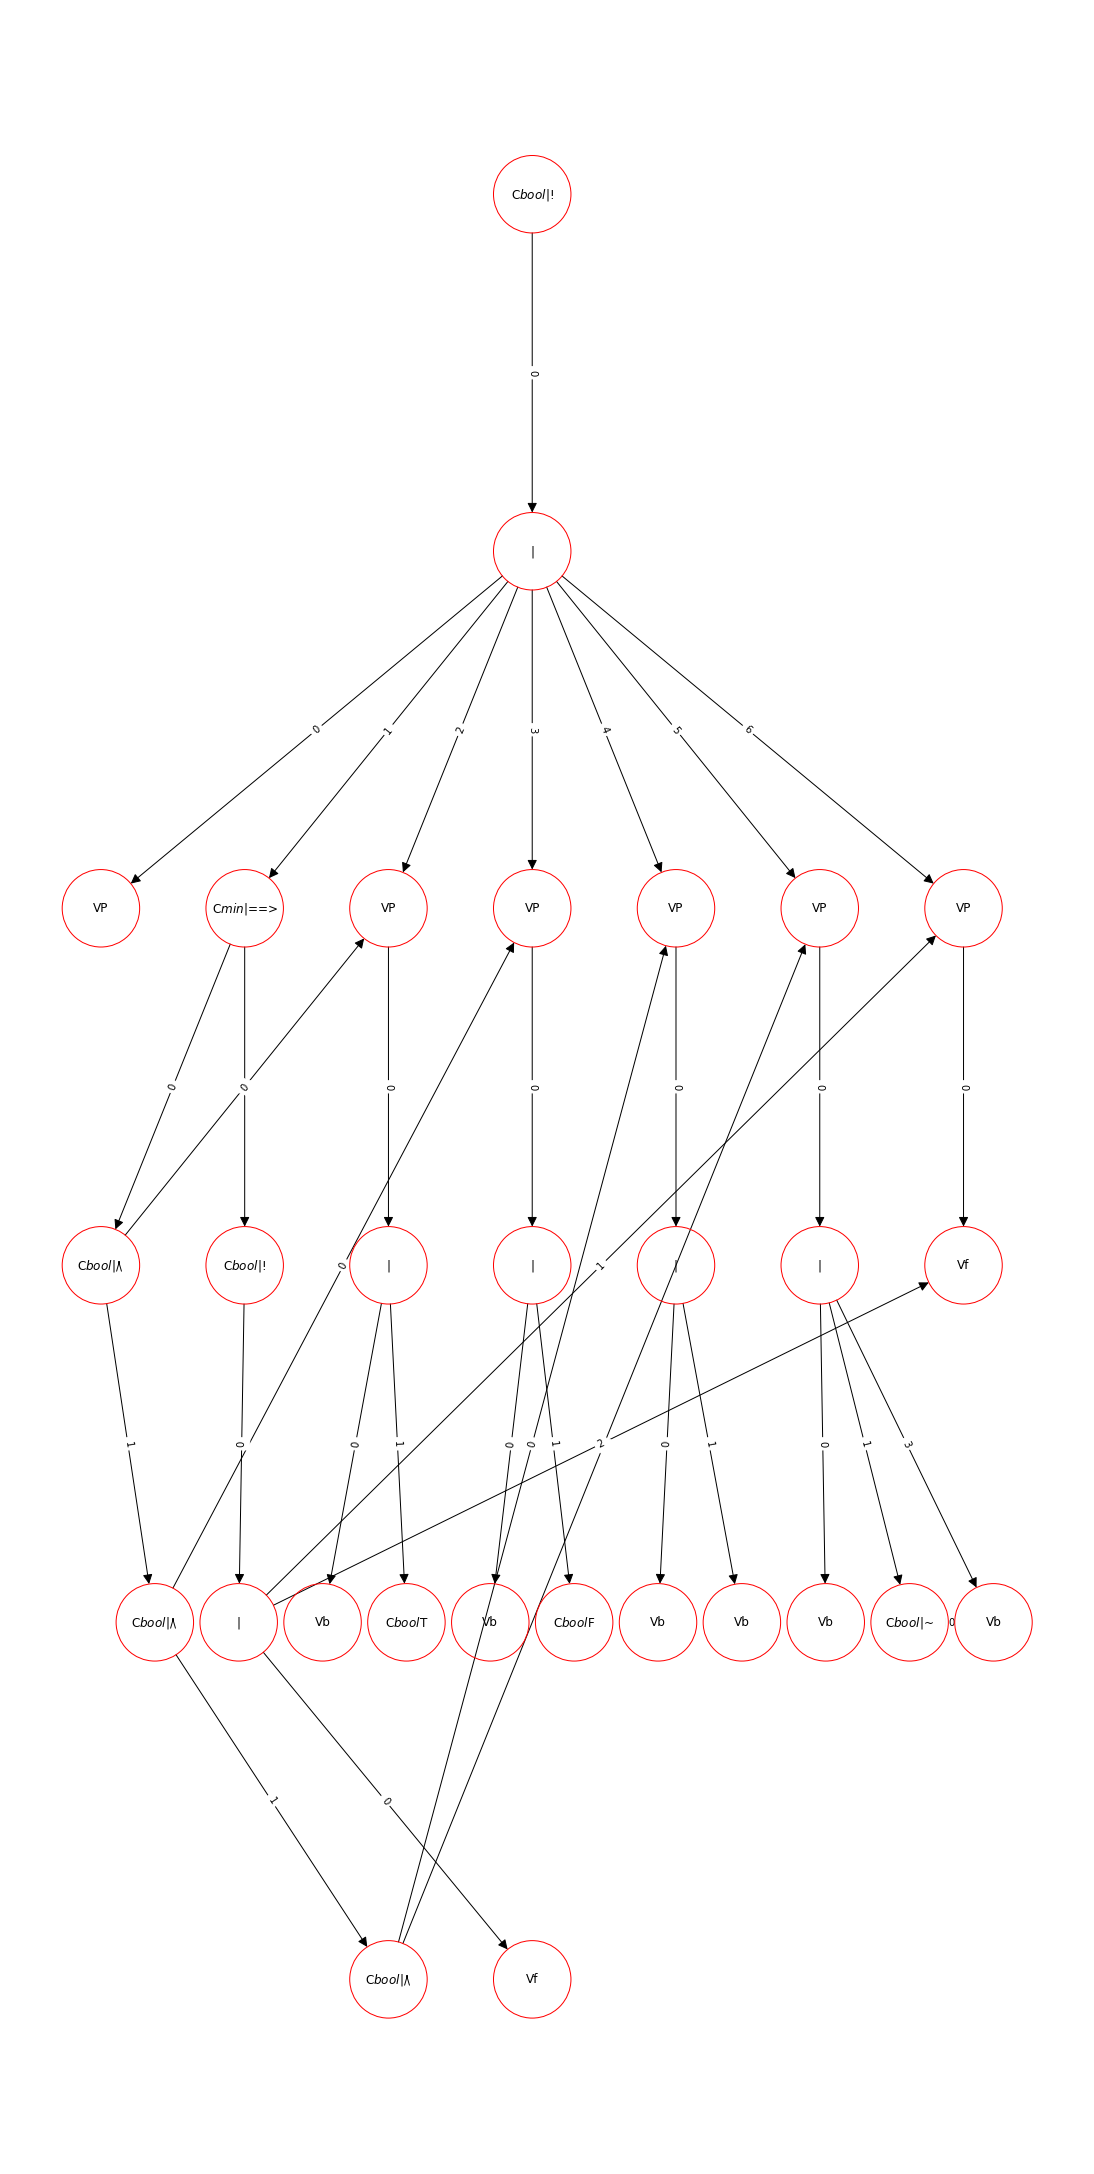

In [27]:
print_graph(process_lambdas(tokens_to_ast(polished_to_tokens_2(polished_goals[2081]))))


In [ ]:
get_

In [77]:
[i for i in db.values() if i[2] == polished_goals[2406]]

[[' pair',
  'prod_TY_DEF',
  '@ C$bool$ ? | Vrep @ @ C$bool$ TYPE_DEFINITION | Vp @ C$bool$ ? | Vx @ C$bool$ ? | Vy @ @ C$min$ = Vp | Va | Vb @ @ C$bool$ /\\ @ @ C$min$ = Va Vx @ @ C$min$ = Vb Vy Vrep',
  '0',
  'def',
  '∃(rep :α # β -> α -> β -> bool). TYPE_DEFINITION  (λ(p :α -> β -> bool).   ∃(x :α) (y :β). p = (λ(a :α) (b :β). a = x ∧ b = y)) rep']]